# Reading the datasets

In [14]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Importing the necessary libraries

In [15]:
import matplotlib.pyplot as plt     #for data plots/visualization
import seaborn as sns     #to make plot of pnumonia/normal labels in training data
import keras       #neural network modelling
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split  #splitting data into training and testing
from sklearn.metrics import classification_report,confusion_matrix  #performance= accuracy, f1 score
from keras.callbacks import ReduceLROnPlateau
import cv2   #image processing
import os    #file manipulation, directory operations, 

# Labelling and Resizing

In [16]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [ ]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

# Data Visualization & Preprocessing

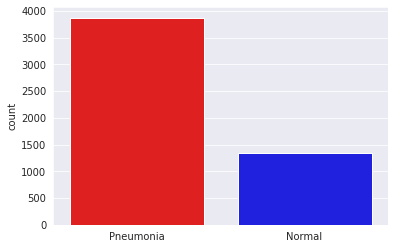

In [37]:
l = []
for i in train:
    if(i[1] == 0): #if the image label is 0 then pneumonia else normal 
        l.append("Pneumonia")
    else:
        l.append("Normal")
        
sns.set_style('darkgrid')

custom_palette = {"Pneumonia": "red", "Normal": "blue"}

# Create the countplot with custom colors
sns.countplot(l, palette=custom_palette)


**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

In [20]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [21]:
# Normalize the data to make it btw the scale of 0-1
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [22]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)  #[batch_size, height, width, channels]
#here single channel bcz of grayscale
#150-150 img size
#batch-size is the no of images to be reshaped
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [23]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
# datagen: This is an object of the ImageDataGenerator class in Keras. It's responsible for generating augmented images based on the original training data.
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening to reduce redundancy and improve convergence of learning algo
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

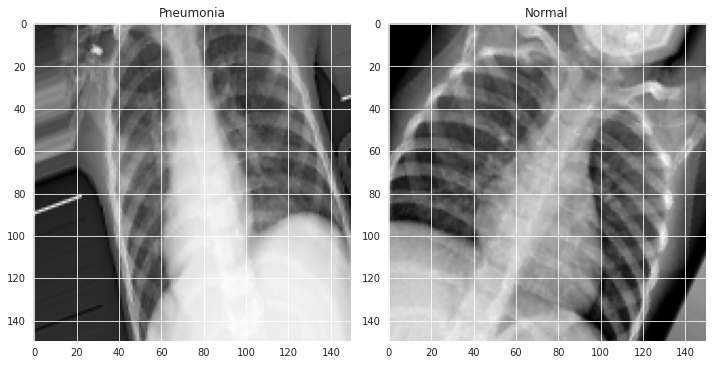

In [43]:
# Generate augmented images
augmented_images = datagen.flow(x_train, y_train, batch_size=1)

# Visualize augmented images
plt.figure(figsize=(10, 5))

# Initialize variables to store augmented images
pneumonia_image = None
normal_image = None

# Plot the augmented images
for _ in range(len(x_train)):
    image, label = augmented_images.next()
    if label[0] == 0:  # Pneumonia
        pneumonia_image = image.squeeze()
    else:  # Normal
        normal_image = image.squeeze()

# Plot the first augmented image (pneumonia)
plt.subplot(1, 2, 1)
plt.imshow(pneumonia_image, cmap='gray')
plt.title("Pneumonia")

# Plot the second augmented image (normal)
plt.subplot(1, 2, 2)
plt.imshow(normal_image, cmap='gray')
plt.title("Normal")

plt.tight_layout()
plt.show()


# Training the Model

In [24]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 38, 38, 64)       

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [26]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 263s 2s/step - loss: 0.6453 - accuracy: 0.8359 - val_loss: 30.1196 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 265s 2s/step - loss: 0.2697 - accuracy: 0.8986 - val_loss: 44.9890 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 264s 2s/step - loss: 0.2492 - accuracy: 0.9155 - val_loss: 59.2805 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
163/163 [==============================] - 264s 2s/step - loss: 0.1577 - accuracy: 0.9417 - val_loss: 63.7523 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 264s 2s/step - loss: 0.1386 - accuracy: 0.9519 - val_loss: 0.4518 - val_accuracy: 0.6250
Epoch 6/12
163/163 [==============================] - 266s 2s/step - loss: 0.1321 - accuracy: 0.9571 - val_loss: 1.4229 - val_accuracy: 0.6250
Epoch 7/12
163/163 [==============================] - 264

In [27]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 8s 14ms/step
Loss of the model is -  0.3159052399106515
624/624 [==============================] - 8s 13ms/step
Accuracy of the model is -  91.50640964508057 %


# Analysis after Model Training

In [30]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.92      0.94      0.93       390
   Normal (Class 1)       0.90      0.87      0.89       234

           accuracy                           0.92       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.91      0.92      0.91       624



**Some of the Correctly Predicted Classes**

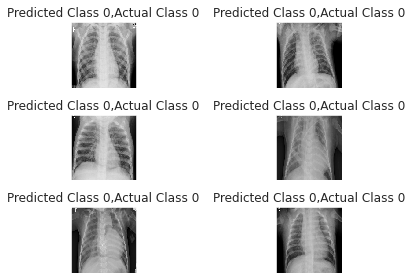

In [35]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

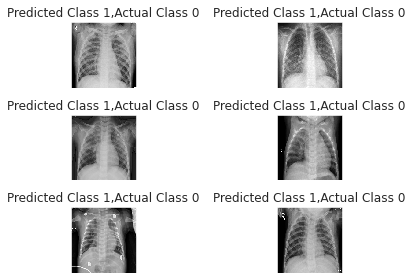

In [36]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1